In [22]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


data = pd.read_csv('Data/train_all_dummies.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

np.random.seed(42)
idx = np.random.choice(range(len(data)),int(10e2) , replace=False)
smaller_data = data.iloc[idx]

X,y = smaller_data.drop('diagnosed_diabetes', axis=1), smaller_data['diagnosed_diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

X_train

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,smoking_status_Current,smoking_status_Former,smoking_status_Never,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed
73635,40,2,38,3.5,6.9,4.2,30.4,0.92,110,80,...,0,1,0,0,0,1,1,0,0,0
486581,58,3,68,5.9,7.3,4.4,27.8,0.86,111,84,...,0,1,0,1,0,0,1,0,0,0
666987,60,1,41,6.9,7.6,5.5,26.8,0.86,122,69,...,0,0,1,0,0,1,1,0,0,0
348689,49,1,89,4.3,8.9,3.9,27.9,0.89,108,68,...,0,0,0,0,0,1,1,0,0,0
688424,53,2,112,4.1,8.8,8.7,30.7,0.95,120,80,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620375,61,2,61,6.8,7.9,5.2,23.3,0.80,118,67,...,0,1,0,0,1,0,1,0,0,0
30886,30,3,125,7.4,6.1,4.5,25.9,0.89,95,71,...,0,0,1,0,0,1,0,1,0,0
693218,29,3,76,6.7,7.5,6.3,27.0,0.88,106,74,...,0,1,0,0,0,1,0,0,0,1
552266,64,1,17,6.9,7.3,7.2,21.6,0.79,118,80,...,0,1,0,0,0,1,0,1,0,0


# Metric Function

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       207
         1.0       1.00      1.00      1.00       393

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



{'accuracy': 1.0, 'roc_score': 1.0}

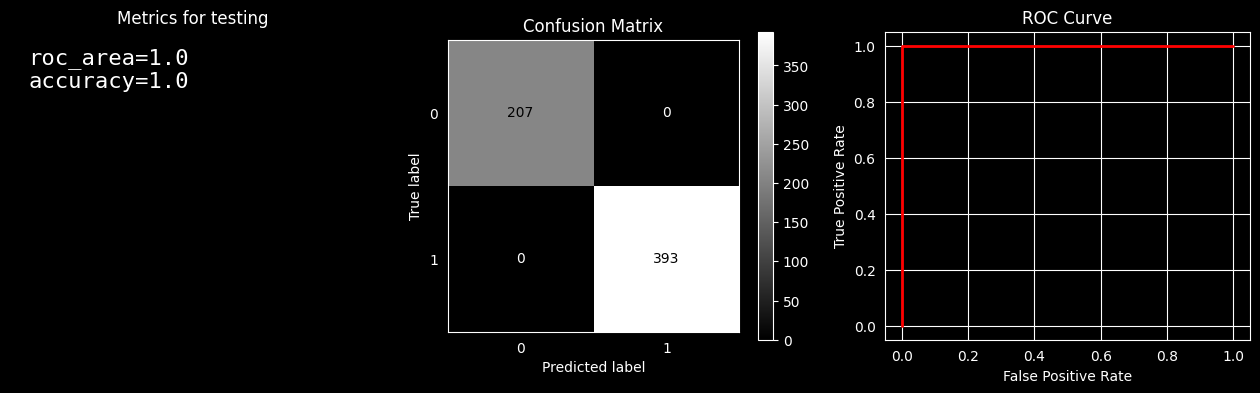

In [23]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, \
    roc_curve, classification_report


def metrics(preds:np.ndarray, probs:np.ndarray, lables:np.ndarray, method:str):
    cf_mtx = confusion_matrix(lables, preds)
    fpr, tpr, thresholds = roc_curve(lables, probs)
    roc_area = roc_auc_score(lables, probs)
    accuracy = accuracy_score(lables, preds)

    print(classification_report(lables, preds))

    text = f"{roc_area=}\n{accuracy=}"

    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx)
    roc_disp = RocCurveDisplay(fpr=fpr,tpr=tpr)

    fig, (ax_report, ax_matrix, ax_roc) = plt.subplots(1, 3, figsize=(16, 4))
    ax_report.text(
        x=0.05,
        y=0.95,
        s=text,
        family='monospace',
        fontsize=16,
        verticalalignment='top',
        transform=ax_report.transAxes)
    ax_report.set_title(f'Metrics for {method}')
    ax_report.axis('off')

    ax_matrix.set_title("Confusion Matrix")
    ax_matrix.grid(False)
    ax_matrix = cf_mtx_disp.plot(ax=ax_matrix, cmap='grey')

    ax_roc.set_title('ROC Curve')
    ax_roc.plot(fpr,tpr, linewidth=2, label='ROC Curve', color='red')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')


    return {"accuracy": accuracy, "roc_score": roc_area}


metrics(y_train,y_train,y_train, "testing")

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

from typing import Literal


def ulitmate_objective_generator(scaler_name:Literal['standard', 'minmax', 'robust'], selector_name:Literal['RFE', 'Kbest'], model_name:Literal['Logistic', 'KNN', 'Forest', 'SVM'], features_quantity:int = 42):
    scaler_class = None
    model_class = None

    if scaler_name == 'standard':
        scaler_class = StandardScaler

    elif scaler_name == 'minmax':
        scaler_class = MinMaxScaler

    elif scaler_name == 'robust':
        scaler_class = RobustScaler

    if selector_name == 'RFE':
        selector_class = RFE
    elif selector_name == 'Kbest':
        selector_class = SelectKBest


    if model_name == 'Logistic':
        model_class = LogisticRegression
    elif model_name == 'KNN':
        model_class = KNeighborsClassifier
    elif model_name == 'Forest':
        model_class = RandomForestClassifier
    elif model_name == 'SVM':
        model_class = SVC


    def objective(trial):
        #Scalers
        nonlocal scaler_class, model_class
        model_params = {}
        scaler_params = {}

        if scaler_class is StandardScaler:

            scaler_params = {}

        if scaler_class is MinMaxScaler:
            clip = trial.suggest_categorical('scaler__clip', [True, False])

            scaler_params = {'clip': clip}

        if scaler_class is RobustScaler:
            with_centering=trial.suggest_categorical('scaler__with_centering', [True, False])
            quantile_range = trial.suggest_categorical('scaler__quantile_range', [(0.1, 0.9), (0.25, 0.75), (0.3, 0.7), (0.4, 0.6)])

            scaler_params = {'with_scaling': True, 'with_centering': with_centering, 'quantile_range': quantile_range}

         # Feature Selection
        if selector_class is RFE:
            n_features_to_select = trial.suggest_int('features_selector__n_features_to_select', 1, features_quantity)

        if selector_class is SelectKBest:
            k = trial.suggest_int('features_selector__k', 1, features_quantity)


        # Models
        if model_class is LogisticRegression:
            C = trial.suggest_float('classifier__C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('classifier__solver', ['lbfgs', 'liblinear', 'saga'])
            max_iter = trial.suggest_int('classifier__max_iter', 100, 2000)

            model_params = {'C': C, 'solver': solver, 'max_iter': max_iter}

        if model_class is KNeighborsClassifier:
            n_neighbors = trial.suggest_int("classifier__n_neighbors", 1, 80)
            weights = trial.suggest_categorical('classifier__weights', ['uniform', 'distance'])
            metric  = trial.suggest_categorical('classifier__metric', ['manhattan', 'euclidean','minkowski'])

            model_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

        if model_class is RandomForestClassifier:
            model_params = {
                "n_estimators": trial.suggest_int("classifier__n_estimators", 10, 500),
                "max_depth": trial.suggest_int("classifier__max_depth", 2, 32, log=True),
                "min_samples_split": trial.suggest_int("classifier__min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("classifier__min_samples_leaf", 1, 20),
                "criterion": trial.suggest_categorical("classifier__criterion", ["gini", "entropy"]),
            }

        if model_class is SVC:
            model_params = {'kernel': trial.suggest_categorical("classifier__kernel", ["linear", "poly", "rbf", "sigmoid"]),
                            'gamma': trial.suggest_categorical("classifier__gamma", ["scale", "auto"]),
                            'C': trial.suggest_float("classifier__C", 1e-3, 1),
                            'probability': trial.suggest_categorical('classifier__probability', [True])}


        if selector_class is RFE:
            pipe = Pipeline([('scaler', scaler_class(**scaler_params)),('features_selector', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)) ,
                         ('classifier', model_class(**model_params))])

        if selector_class is SelectKBest:
            pipe = Pipeline([('scaler', scaler_class(**scaler_params)),('features_selector', SelectKBest(score_func=f_regression, k=k)) ,('classifier', model_class(**model_params))])

        pipe.fit(X_train, y_train)
        score = roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1])

        return score

    if selector_class is RFE:
        new_pipe = Pipeline([('scaler', scaler_class()),('features_selector', RFE(estimator=DecisionTreeClassifier())) ,
                         ('classifier', model_class())])

    if selector_class is SelectKBest:
        new_pipe = Pipeline([('scaler', scaler_class()),('features_selector', SelectKBest(score_func=f_regression)) ,('classifier', model_class())])

    return [new_pipe, objective]

# Optim and Train Fucntion

In [25]:
import time
import optuna
import warnings
warnings.filterwarnings("ignore")
optuna.logging.disable_default_handler()


names = X_train.columns

def selected_features(selector):
    global names

    mask = selector.get_support()
    selected_names = np.array(names)[mask]
    return list(selected_names)

def optimize_train_and_judge(title, pipe, objective_fn, trails=100):
    global X_train, y_train,X_val, y_val, X_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()

    pipe.set_params(**study.best_params)
    pipe.fit(X_train, y_train)


    ## Metrics
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]
    metrics(preds, probs, y_test, title)

    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    features_shape = [X_test.shape[0], len(names_selected)]
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")

    return pipe

# Objective Generation

In [26]:
models_names = ['Logistic', 'KNN', 'Forest', 'SVM']
scalers_names = ['standard', 'minmax', 'robust']
selector_names = ['RFE', 'Kbest']

optim_pipes = {}
pipe_names = []

for m in models_names:
    for s in scalers_names:
        for f in selector_names:
            name = f"{s}_{f}_{m}"
            pipe_names.append(name)
            optim_pipes[name] = ulitmate_objective_generator(s, f, m)


optim_pipes

{'standard_RFE_Logistic': [Pipeline(steps=[('scaler', StandardScaler()),
                  ('features_selector', RFE(estimator=DecisionTreeClassifier())),
                  ('classifier', LogisticRegression())]),
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'standard_Kbest_Logistic': [Pipeline(steps=[('scaler', StandardScaler()),
                  ('features_selector',
                   SelectKBest(score_func=<function f_regression at 0x72d61d2b6340>)),
                  ('classifier', LogisticRegression())]),
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'minmax_RFE_Logistic': [Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('features_selector', RFE(estimator=DecisionTreeClassifier())),
                  ('classifier', LogisticRegression())]),
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'minmax_Kbest_Logistic': [Pipeline(steps=[('scaler', MinMaxScaler()),
          

# Optim

In [ ]:
import pickle

pipe_names = optim_pipes.keys()

ready_pipes = {}
for n in pipe_names:
    print(n)
    ready_pipes[n] = optimize_train_and_judge(n, optim_pipes[n][0], optim_pipes[n][1], trails=1)

    with open(f'models/{n}.pkl', 'wb') as f:
        pickle.dump(ready_pipes[n], f)


standard_RFE_Logistic


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-12-25 23:07:53,975] A new study created in memory with name: no-name-7b5bcb20-8164-43fd-bb96-81f5a9b78cdc


[I 2025-12-25 23:07:53,840] Trial 0 finished with value: 0.5518267651888342 and parameters: {'features_selector__n_features_to_select': 39, 'classifier__C': 46.57676963530772, 'classifier__solver': 'liblinear', 'classifier__max_iter': 1178}. Best is trial 0 with value: 0.5518267651888342.
              precision    recall  f1-score   support

         0.0       0.55      0.30      0.38        81
         1.0       0.63      0.83      0.72       119

    accuracy                           0.61       200
   macro avg       0.59      0.56      0.55       200
weighted avg       0.60      0.61      0.58       200

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_his

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-12-25 23:07:54,031] Trial 0 finished with value: 0.5770730706075534 and parameters: {'features_selector__k': 5, 'classifier__C': 0.0039616831022441235, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 259}. Best is trial 0 with value: 0.5770730706075534.


[I 2025-12-25 23:07:54,195] A new study created in memory with name: no-name-13e2f557-08d6-4003-ac0e-ceec2a21f4b3


              precision    recall  f1-score   support

         0.0       1.00      0.02      0.05        81
         1.0       0.60      1.00      0.75       119

    accuracy                           0.60       200
   macro avg       0.80      0.51      0.40       200
weighted avg       0.76      0.60      0.47       200

Selected features: ['age', 'physical_activity_minutes_per_week', 'bmi', 'family_history_diabetes', 'hypertension_history']
Optimize time: 0.06107044219970703
minmax_RFE_Logistic


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-12-25 23:07:54,597] Trial 0 finished with value: 0.56876026272578 and parameters: {'scaler__clip': True, 'features_selector__n_features_to_select': 5, 'classifier__C': 9.873737854159419, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 976}. Best is trial 0 with value: 0.56876026272578.


[I 2025-12-25 23:07:55,131] A new study created in memory with name: no-name-82f0ed19-f154-4b67-b7af-ea5a991a4851


              precision    recall  f1-score   support

         0.0       0.67      0.10      0.17        81
         1.0       0.61      0.97      0.75       119

    accuracy                           0.61       200
   macro avg       0.64      0.53      0.46       200
weighted avg       0.63      0.61      0.52       200

Selected features: ['physical_activity_minutes_per_week', 'bmi', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides']
Optimize time: 0.4051041603088379
minmax_Kbest_Logistic


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-12-25 23:07:55,172] Trial 0 finished with value: 0.5332512315270936 and parameters: {'scaler__clip': True, 'features_selector__k': 1, 'classifier__C': 0.005188375760100158, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 1334}. Best is trial 0 with value: 0.5332512315270936.
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        81
         1.0       0.59      1.00      0.75       119

    accuracy                           0.59       200
   macro avg       0.30      0.50      0.37       200
weighted avg       0.35      0.59      0.44       200



[I 2025-12-25 23:07:55,305] A new study created in memory with name: no-name-e71bd8bf-865d-4235-8692-f6da2460e3e0
